# Module 1 Project: King County House Sales Price Projection


# Part I: Obtain the data and data scrubbing



* Cast columns to the appropriate data types
* Identify and deal with null values appropriately
* Remove unnecessary columns
* Check for and deal with multicollinearity
* Normalize our data


In [382]:
#import libraries and data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from collections import Counter

In [383]:
kcdata = pd.read_csv("kc_house_data.csv")

In [384]:
kcdata.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [385]:
kcdata.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

## Deal with missing values

In [386]:
#Find missing value: waterfront, view, yr_renovated, and incorrect data type: sqft_basement
kcdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [387]:
kcdata['sqft_basement'].unique();

In [388]:
#For Categorical data 'Waterfront', replace NAN with 0 since it is highly possible that the house doesn't have a waterfront. 
kcdata['waterfront'].unique()
kcdata['waterfront'] = kcdata['waterfront'].fillna(0)

counter = Counter()
counter = Counter(kcdata['waterfront'])
print(counter)

Counter({0.0: 21451, 1.0: 146})


For view, this variable presents how many times people have viewed the house. Based on common sense, number of times being viewed should not decide the house price. Plus, majority of the values are zero. So we will replace NAN with 0 now and create bins: {0: nobody viewed, 1-2, 3-4}

In [389]:
kcdata['view'].unique()
kcdata['view'] = kcdata['view'].fillna(0)
counter = Counter()
counter = Counter(kcdata['view'])
print(counter)


Counter({0.0: 19485, 2.0: 957, 3.0: 508, 1.0: 330, 4.0: 317})


In [390]:
#There are too many missing values in yr_renovated. And it may not be fair to replace NAN with average. 
#So we will probably not consider this variable into the model.We will fill NaN and remove this column now.
%matplotlib inline
kcdata['yr_renovated'].fillna(0);
kcdata = kcdata.drop('yr_renovated', axis =1);
#kcdata['yr_renovated'].hist()

In [391]:
kcdata.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.006760,0.233181,3.409825,7.657915,1788.596842,1970.999676,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.081944,0.764673,0.650546,1.173200,827.759761,29.375234,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [392]:
kcdata.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Cast columns to the appropriate data types

Obvious fix: change date from string to datetime, sqft_basement to continuous, waterfront as categorical

Condition and grade are ordinal variables with limited values. View and Floors have limited values too. Can group them into bins. 

In [393]:
#Convert strings into dates
from datetime import datetime
kcdata['date'].head()
f = lambda x: datetime.strptime(x,'%m/%d/%Y')
kcdata['date']=kcdata['date'].apply(f)
kcdata.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,98074,47.6168,-122.045,1800,7503


In [394]:
#Convert sqft_basement column from string to numerical
kcdata['sqft_basement'].value_counts()

#Replace ? with zeros for now.
kcdata['sqft_basement'] = kcdata['sqft_basement'].replace('?','0')


kcdata['sqft_basement'] = kcdata['sqft_basement'].astype(float)
kcdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(11)
memory usage: 3.3 MB


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

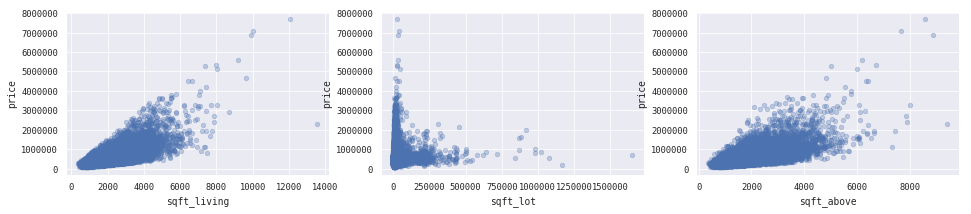

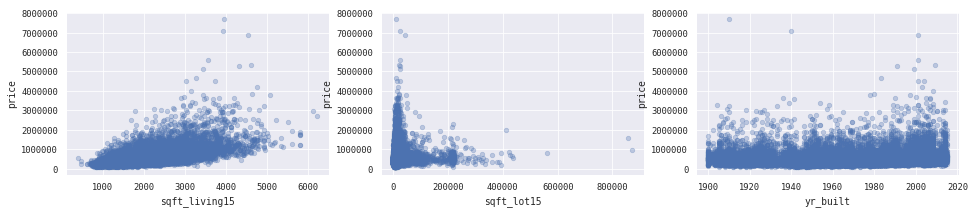

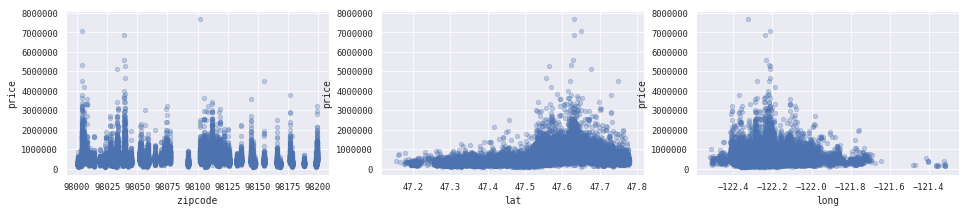

In [395]:
#Plotting potential continuous variables

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
con_list = ['sqft_living','sqft_lot','sqft_above']

for xcol, ax in zip(con_list, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
con_list2 =['sqft_living15','sqft_lot15','yr_built']

for xcol, ax in zip(con_list2, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3)
    
#Plotting zipcode

fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(16,3))
geo_list = ['zipcode','lat','long']

for xcol, ax in zip(geo_list, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3)


Observation: From the scattered plots above, we can tell sqft_living, sqft_above, sqft_living15 have positive correlation with house price, while yr_built and zipcode do not have obvious relationship with house price. Also from the plot, we can tell that the shape of sqft_living and sqft_living15 are similar while sqft_lot and sqft_lot15 are very similar too. So probably these two sets of variables are highly correlated.

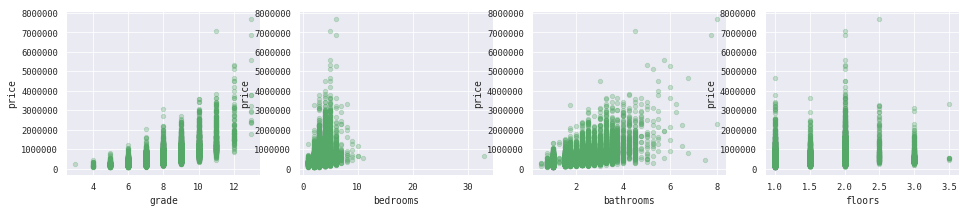

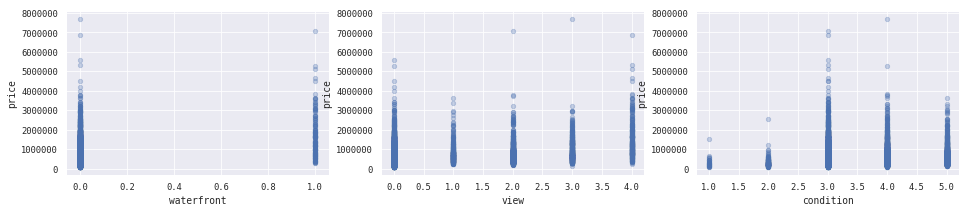

In [396]:
#Plotting other variables. Waterfront is clearly categorical values with binominal values. 
#While view, condition, grade, bedrooms, bathrooms, and floors present actual numerical values so we can either keep them numerical or transform them into categorical values. 

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
cat_list1 = ['grade','bedrooms', 'bathrooms','floors']


for xcol, ax in zip(cat_list1, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3, color='g')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))    
cat_list2=['waterfront', 'view', 'condition']
for xcol, ax in zip(cat_list2, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3, color='b')

## Turn condition to dummy columns

In [397]:

kcdata['view']=kcdata['view'].fillna(0)
kcdata['view'] = kcdata['view'].astype(int)


In [398]:
view_dummies = pd.get_dummies(kcdata['view'], prefix='view')


In [399]:
condition_dummies = pd.get_dummies(kcdata['condition'], prefix='con')

In [400]:
kcdata=pd.concat([kcdata,view_dummies,condition_dummies], axis=1)

In [401]:
kcdata[['condition','con_1','con_2','con_3','con_4','con_5']].head(20)

,condition,con_1,con_2,con_3,con_4,con_5
0,3,0,0,1,0,0
1,3,0,0,1,0,0
2,3,0,0,1,0,0
3,5,0,0,0,0,1
4,3,0,0,1,0,0
5,3,0,0,1,0,0
6,3,0,0,1,0,0
7,3,0,0,1,0,0
8,3,0,0,1,0,0
9,3,0,0,1,0,0


## Convert Waterfront to binominal 

In [402]:

kcdata['waterfront'] = kcdata['waterfront'].astype('category')
kcdata['waterfront'].cat.codes;

## Create Bins for grade, bedrooms, bathrooms, years and floors

Although grade, bedrooms, bathrooms and floors are numerical values, it is diffidult to justify a linear pattern between these variables and target here. For example, grade 2 may not mean it is twice better than grade 1, or worse. It might make sense to restructure data into bins so that they are treated as categorical variables.

#### GRADE

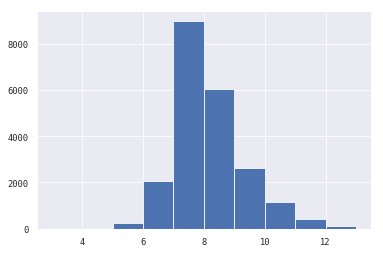

In [403]:
kcdata['grade'].describe()
kcdata['grade'].hist()

In [404]:
bins = [3,7,8,10,13]
bins_grade = pd.cut(kcdata['grade'],bins)

In [405]:

bins_grade = bins_grade.cat.as_unordered()



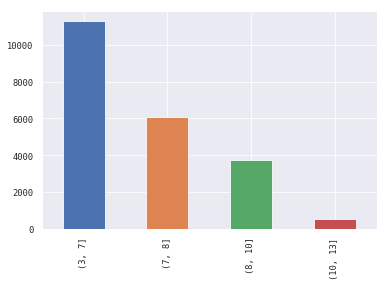

In [406]:
bins_grade.value_counts().plot(kind='bar')
kcdata['grade']=bins_grade

#### BEDROOMS

In [407]:
kcdata['bedrooms'].describe()

count    21597.000000
mean         3.373200
std          0.926299
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

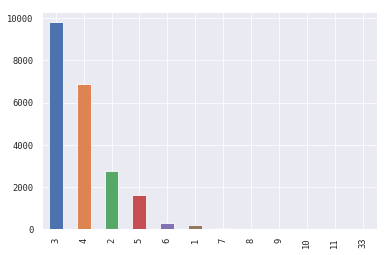

In [408]:
kcdata['bedrooms'].value_counts().plot(kind='bar')

There might be an outlier 33 in the bedroom variable. 

In [409]:
#The observation doesn't make sense, a house with 33 bedrooms only have 1040 sqft above the basement.
kcdata[kcdata['bedrooms']==33].sqft_above

15856    1040
Name: sqft_above, dtype: int64

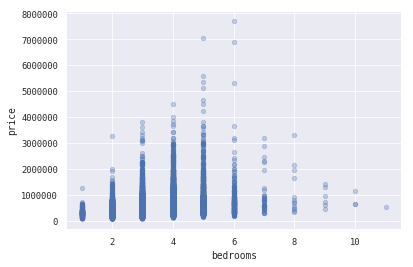

In [410]:
#Remove the max value from bedrooms
o = kcdata['bedrooms'].max()
kcdata = kcdata[kcdata['bedrooms']< o]
kcdata.plot(kind='scatter', x='bedrooms', y='price', alpha=0.3, color='b');


In [411]:
kcdata['bedrooms'].describe()

count    21596.000000
mean         3.371828
std          0.904114
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         11.000000
Name: bedrooms, dtype: float64

In [412]:
bins = [1,2,3,4,6,11]
bins_bedroom = pd.cut(kcdata['bedrooms'],bins)
bins_bedroom = bins_bedroom.cat.as_unordered()
bins_bedroom.head()
kcdata['bedrooms']=bins_bedroom

In [413]:
kcdata['bedrooms'].value_counts()

(2, 3]     9824
(3, 4]     6882
(1, 2]     2760
(4, 6]     1873
(6, 11]      61
Name: bedrooms, dtype: int64

#### BATHROOMS

In [414]:
kcdata['bathrooms'].describe()
#kcdata['bathrooms'].value_counts();

count    21596.000000
mean         2.115843
std          0.768998
min          0.500000
25%          1.750000
50%          2.250000
75%          2.500000
max          8.000000
Name: bathrooms, dtype: float64

The definition of 'bathrooms' is the number of bathrooms per bedrooms. Normally a residential building have 0.5-2 bathrooms per bedroom. So 3-8 bathrooms per bedroom may suggest there are different kinds of buildings. We can investigate the sqft_above and price to see if any outliers. 

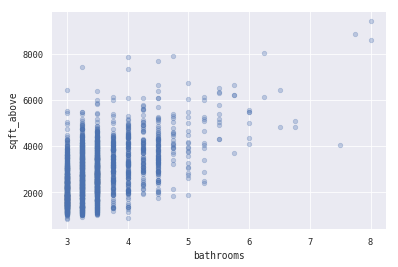

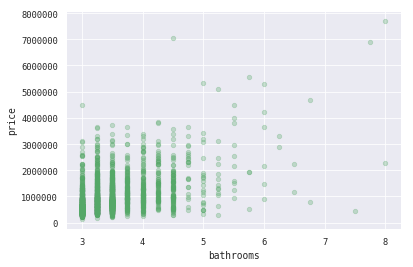

In [415]:
kcdata[kcdata['bathrooms']>=3].groupby('bathrooms').sqft_above.mean()
b = kcdata[kcdata['bathrooms']>=3]
b.plot(kind='scatter', x='bathrooms', y='sqft_above', alpha=0.3, color='b')
b.plot(kind='scatter', x='bathrooms', y='price', alpha=0.3, color='g')


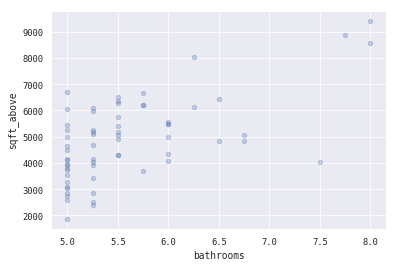

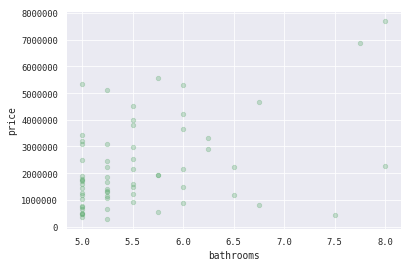

In [416]:
#Check bathrooms >5. 
kcdata[kcdata['bathrooms']>=5].groupby('bathrooms').sqft_above.mean()
a = kcdata[kcdata['bathrooms']>= 5]
a.plot(kind='scatter', x='bathrooms', y='sqft_above', alpha=0.3, color='b')
a.plot(kind='scatter', x='bathrooms', y='price', alpha=0.3, color='g')


We will create bins for bathrooms for now. 

In [417]:
bins = [0.5,1.5,2,2.5,5,8]
bins_bathroom = pd.cut(kcdata['bathrooms'],bins)
bins_bathroom = bins_bathroom.cat.as_unordered()
bins_bathroom.head()
kcdata['bathrooms']=bins_bathroom

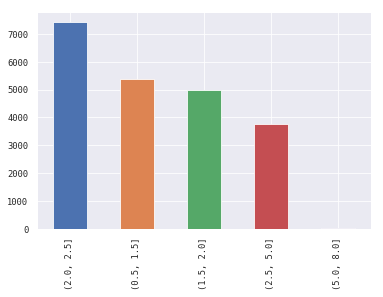

In [418]:
kcdata['bathrooms'].value_counts().plot(kind='bar')

#### FLOORS

In [419]:
kcdata['floors'].describe()

count    21596.000000
mean         1.494119
std          0.539685
min          1.000000
25%          1.000000
50%          1.500000
75%          2.000000
max          3.500000
Name: floors, dtype: float64

In [420]:
bins = [0,1,1.5,2,3.5]
bins_floors = pd.cut(kcdata['floors'],bins)
bins_floors = bins_floors.cat.as_unordered()
bins_floors.head()
kcdata['floors']=bins_floors

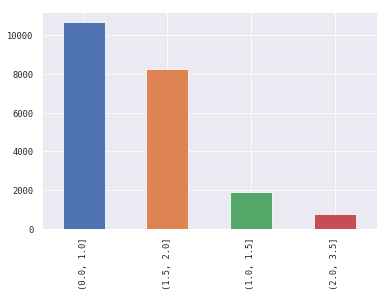

In [421]:
kcdata['floors'].value_counts().plot(kind='bar')

#### Year Built

In [422]:
kcdata['yr_built'].describe()

count    21596.000000
mean      1971.000787
std         29.375460
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64

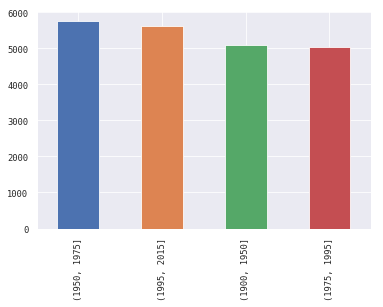

In [423]:
bins = [1900,1950,1975,1995,2015]
bins_year = pd.cut(kcdata['yr_built'],bins)
bins_year = bins_year.cat.as_unordered()
bins_year.head()
kcdata['yr_built']=bins_year

kcdata['yr_built'].value_counts().plot(kind='bar')

In [424]:
kcdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 30 columns):
id               21596 non-null int64
date             21596 non-null datetime64[ns]
price            21596 non-null float64
bedrooms         21400 non-null category
bathrooms        21592 non-null category
sqft_living      21596 non-null int64
sqft_lot         21596 non-null int64
floors           21596 non-null category
waterfront       21596 non-null category
view             21596 non-null int64
condition        21596 non-null int64
grade            21595 non-null category
sqft_above       21596 non-null int64
sqft_basement    21596 non-null float64
yr_built         21509 non-null category
zipcode          21596 non-null int64
lat              21596 non-null float64
long             21596 non-null float64
sqft_living15    21596 non-null int64
sqft_lot15       21596 non-null int64
view_0           21596 non-null uint8
view_1           21596 non-null uint8
view_2           215

In [425]:
#kcdep[kcdep.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

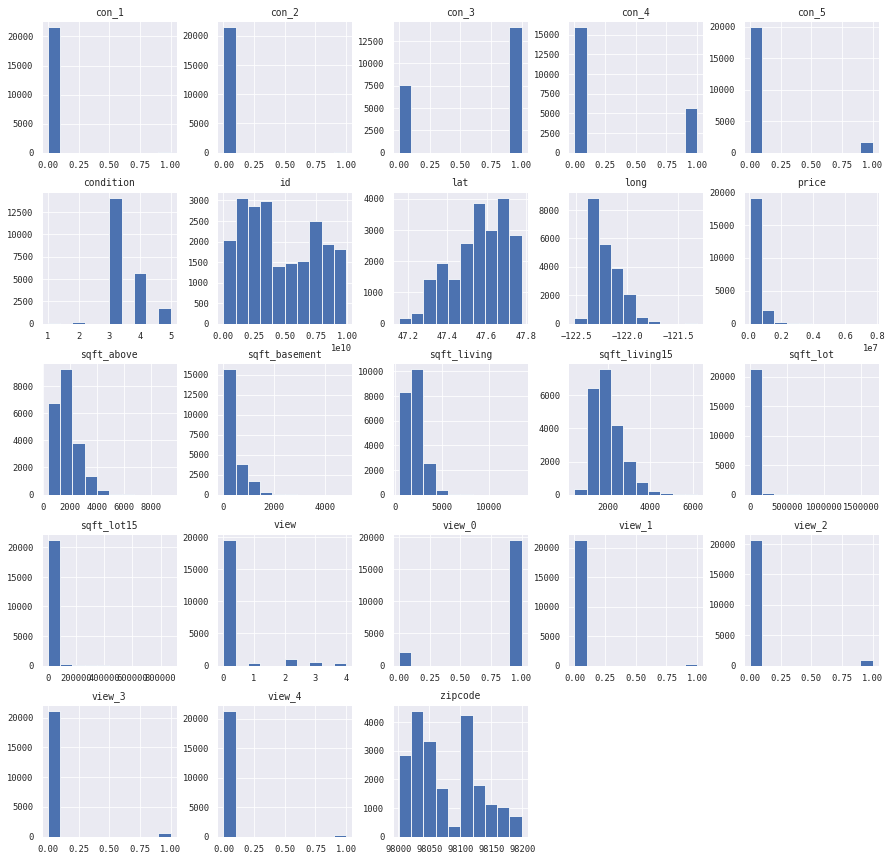

In [426]:
kcdata.hist(figsize=[15,15]);

## Correlation Matrix

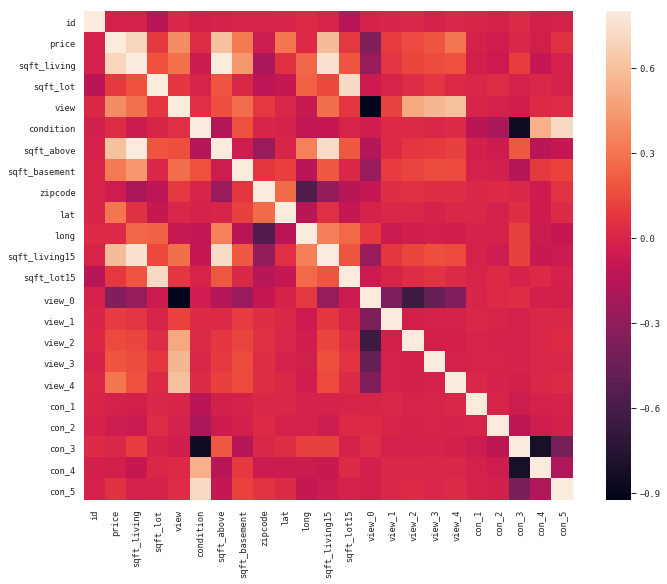

In [427]:
sns.set(context='paper', font='monospace')
corrmat = kcdata.corr()


f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.8, square=True);

Analyzing the heatmap, the variables that are highly correlated to price are:
* sqft_living
* sqft_above
* grade

Independent variables which are highly correlated with each other:

* sqft_living with sqft_living15, bathroom, grade, sqft_above
* grade with bathroom, sqft_above, sqft_living15, sqft_living

## Check Multicolinearity 

In [428]:
## Check Multicolinearity 

kcdata_set = kcdata.iloc[:,3:-1]
kcdata_set.head()
kcdata_set.corr()
abs(kcdata_set.corr()) > 0.75

,sqft_living,sqft_lot,view,condition,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,view_0,view_1,view_2,view_3,view_4,con_1,con_2,con_3,con_4
sqft_living,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
sqft_lot,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
view,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
condition,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
sqft_above,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_basement,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
zipcode,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
lat,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
long,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
sqft_living15,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


The correlation matrix confirms the observation that sqft_living are highly correlated with bathrooms, grade, sqft_above, sqft_living15.

Multicolinearity exists here.

We will drop sqft_living15, sqft_lot15 because they are highly correlated with sqft_living and sqft_lot, and also zipcode, lat, long.

## Feature Scaling and Normalization

In [429]:
#kcdata.info()
kcdata_set = kcdata.drop(columns=['view','condition','sqft_living15','sqft_lot15','zipcode','lat','long'],axis=1)

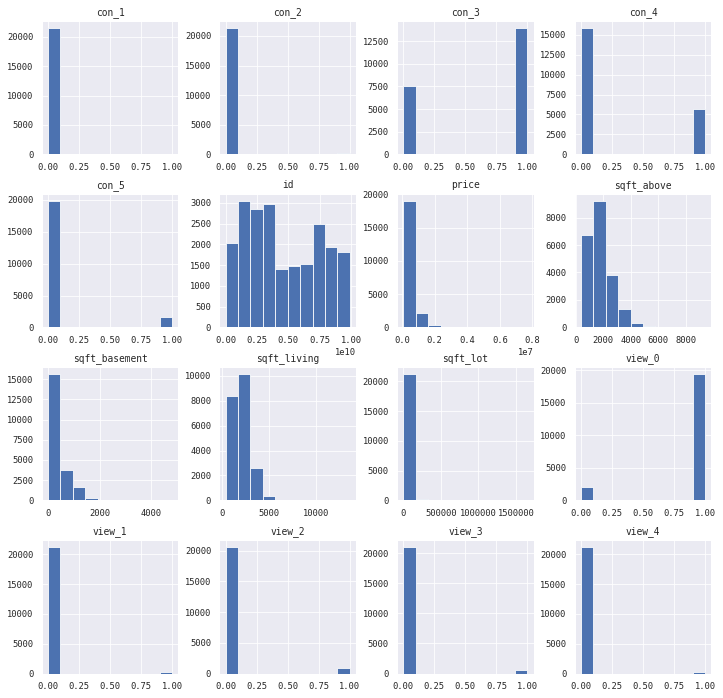

In [430]:
kcdata_set.hist(figsize = [12,12]);

 
Variables with lepto kurtosis: price, sqft_lot
Variables with either positive or negative Skewness: sqft_above, sqft_living

We will perform log transformation to variables with skewness and then do mean normalization. 

### Log Transformation on sqft_above and sqft_living

In [431]:
kcdata_log = pd.DataFrame([])
kcdata_log['sqft_above']=np.log(kcdata_set['sqft_above'])
kcdata_log['sqft_living']=np.log(kcdata_set['sqft_living'])
kcdata_log['price']=np.log(kcdata_set['price'])

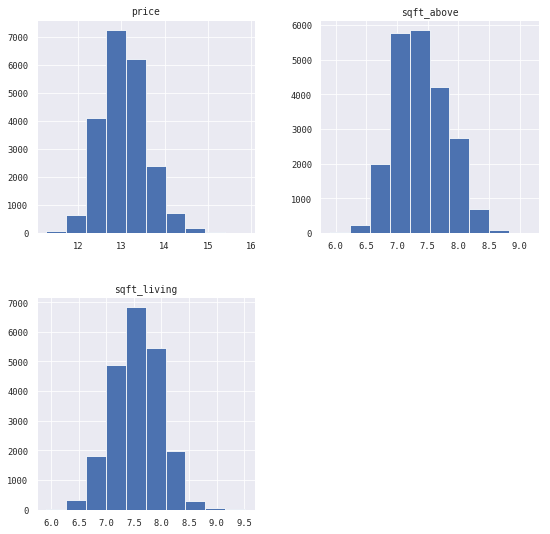

In [432]:
kcdata_log.hist(figsize=[9,9]);

In [433]:
basement = kcdata_set['sqft_basement']
lot = kcdata_set['sqft_lot']
logabove = kcdata_log['sqft_above']
logliving = kcdata_log['sqft_living']
logprice = kcdata_log['price']


scaled_basement= (basement - min(basement))/(max(basement) - min(basement))
scaled_lot = (lot - min(lot))/(max(lot) - min(lot))
scaled_above = (logabove - np.mean(logabove))/np.sqrt(np.var(logabove))
scaled_living = (logliving - np.mean(logliving))/np.sqrt(np.var(logliving))
scaled_price = (logprice - np.mean(logprice))/np.sqrt(np.var(logprice))


kcdata_set['price']=scaled_price
kcdata_set['sqft_living']=scaled_living
kcdata_set['sqft_above']=scaled_above
kcdata_set['sqft_lot']=scaled_lot
kcdata_set['sqft_basement']=scaled_basement



In [434]:
kcdata_set.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,...,view_0,view_1,view_2,view_3,view_4,con_1,con_2,con_3,con_4,con_5
0,7129300520,2014-10-13,-1.401982,"(2, 3]","(0.5, 1.5]",-1.125577,0.003108,"(0.0, 1.0]",0.0,"(3, 7]",...,1,0,0,0,0,0,0,1,0,0
1,6414100192,2014-12-09,0.279969,"(2, 3]","(2.0, 2.5]",0.709431,0.004072,"(1.5, 2.0]",0.0,"(3, 7]",...,1,0,0,0,0,0,0,1,0,0
2,5631500400,2015-02-25,-1.799418,"(1, 2]","(0.5, 1.5]",-2.131918,0.005743,"(0.0, 1.0]",0.0,"(3, 7]",...,1,0,0,0,0,0,0,1,0,0
3,2487200875,2014-12-09,0.499731,"(3, 4]","(2.5, 5.0]",0.070657,0.002714,"(0.0, 1.0]",0.0,"(3, 7]",...,1,0,0,0,0,0,0,0,0,1
4,1954400510,2015-02-18,0.178463,"(2, 3]","(1.5, 2.0]",-0.292744,0.004579,"(0.0, 1.0]",0.0,"(7, 8]",...,1,0,0,0,0,0,0,1,0,0


In [348]:
kcdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 30 columns):
id               21596 non-null int64
date             21596 non-null datetime64[ns]
price            21596 non-null float64
bedrooms         21400 non-null category
bathrooms        21592 non-null category
sqft_living      21596 non-null int64
sqft_lot         21596 non-null int64
floors           21596 non-null category
waterfront       21596 non-null category
view             21596 non-null float64
condition        21596 non-null int64
grade            21595 non-null category
sqft_above       21596 non-null int64
sqft_basement    21596 non-null float64
yr_built         21509 non-null category
zipcode          21596 non-null int64
lat              21596 non-null float64
long             21596 non-null float64
sqft_living15    21596 non-null int64
sqft_lot15       21596 non-null int64
view_0.0         21596 non-null uint8
view_1.0         21596 non-null uint8
view_2.0         2

Resources: https://medium.com/vickdata/four-feature-types-and-how-to-transform-them-for-machine-learning-8693e1c24e80

## Part II: Exploratory Data Analysis

From the data dictionary below we can probably tell some are continuous variables (footage of the home/lot/basement/yr_built) and some might be numerical but more like categorical (number of bathrooms/bedrooms, waterfront, view, condition, grade), and other variables we are not sure (zipcode,lat,long). We will visualize them next.

* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

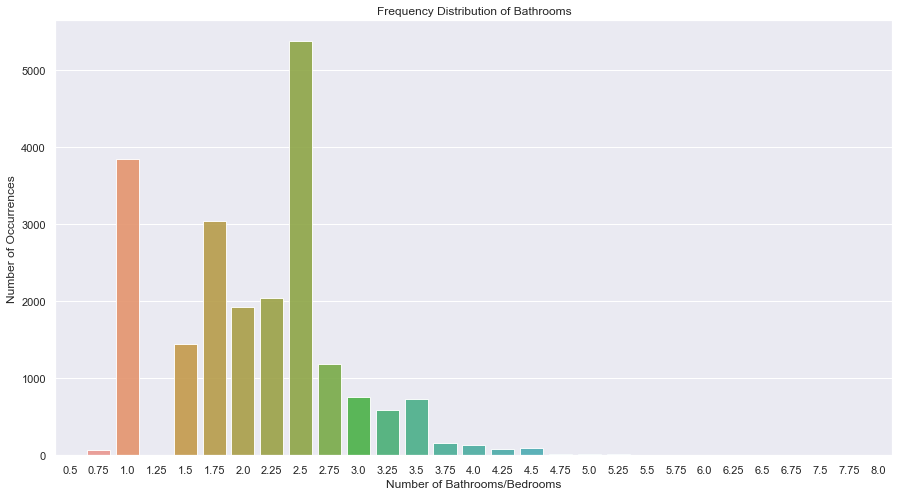

In [32]:
#Value Counts 
#bathroomsNumber - of bathrooms/bedrooms

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
bathroom_count = kcdata['bathrooms'].value_counts()
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
sns.barplot(bathroom_count.index, bathroom_count.values, alpha=0.9)

plt.title('Frequency Distribution of Bathrooms')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of Bathrooms/Bedrooms', fontsize=12)
plt.show()

In [33]:
#Visualize Geolocation data
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

ModuleNotFoundError: No module named 'descartes'

## Part III: Multi-regression Model

In [435]:
data_ols = kcdata_set.iloc[:,2:]
data_ols

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,...,view_0,view_1,view_2,view_3,view_4,con_1,con_2,con_3,con_4,con_5
0,-1.401982,"(2, 3]","(0.5, 1.5]",-1.125577,0.003108,"(0.0, 1.0]",0.0,"(3, 7]",-0.753633,0.000000,...,1,0,0,0,0,0,0,1,0,0
1,0.279969,"(2, 3]","(2.0, 2.5]",0.709431,0.004072,"(1.5, 2.0]",0.0,"(3, 7]",0.672662,0.082988,...,1,0,0,0,0,0,0,1,0,0
2,-1.799418,"(1, 2]","(0.5, 1.5]",-2.131918,0.005743,"(0.0, 1.0]",0.0,"(3, 7]",-1.753047,0.000000,...,1,0,0,0,0,0,0,1,0,0
3,0.499731,"(3, 4]","(2.5, 5.0]",0.070657,0.002714,"(0.0, 1.0]",0.0,"(3, 7]",-1.026909,0.188797,...,1,0,0,0,0,0,0,0,0,1
4,0.178463,"(2, 3]","(1.5, 2.0]",-0.292744,0.004579,"(0.0, 1.0]",0.0,"(7, 8]",0.073468,0.000000,...,1,0,0,0,0,0,0,1,0,0
5,1.850400,"(3, 4]","(2.5, 5.0]",2.468526,0.061429,"(0.0, 1.0]",0.0,"(10, 13]",2.039184,0.317427,...,1,0,0,0,0,0,0,1,0,0
6,-1.119401,"(2, 3]","(2.0, 2.5]",-0.244135,0.003816,"(1.5, 2.0]",0.0,"(3, 7]",0.121742,0.000000,...,1,0,0,0,0,0,0,1,0,0
7,-0.881589,"(2, 3]","(0.5, 1.5]",-1.378402,0.005567,"(0.0, 1.0]",0.0,"(3, 7]",-1.004718,0.000000,...,1,0,0,0,0,0,0,1,0,0
8,-1.338026,"(2, 3]","(0.5, 1.5]",-0.156438,0.004210,"(0.0, 1.0]",0.0,"(3, 7]",-1.026909,0.151452,...,1,0,0,0,0,0,0,1,0,0
9,-0.688991,"(2, 3]","(2.0, 2.5]",-0.015078,0.003659,"(1.5, 2.0]",0.0,"(3, 7]",0.349223,0.000000,...,1,0,0,0,0,0,0,1,0,0


In [436]:
data_ols.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,...,view_0,view_1,view_2,view_3,view_4,con_1,con_2,con_3,con_4,con_5
0,-1.401982,"(2, 3]","(0.5, 1.5]",-1.125577,0.003108,"(0.0, 1.0]",0.0,"(3, 7]",-0.753633,0.000000,...,1,0,0,0,0,0,0,1,0,0
1,0.279969,"(2, 3]","(2.0, 2.5]",0.709431,0.004072,"(1.5, 2.0]",0.0,"(3, 7]",0.672662,0.082988,...,1,0,0,0,0,0,0,1,0,0
2,-1.799418,"(1, 2]","(0.5, 1.5]",-2.131918,0.005743,"(0.0, 1.0]",0.0,"(3, 7]",-1.753047,0.000000,...,1,0,0,0,0,0,0,1,0,0
3,0.499731,"(3, 4]","(2.5, 5.0]",0.070657,0.002714,"(0.0, 1.0]",0.0,"(3, 7]",-1.026909,0.188797,...,1,0,0,0,0,0,0,0,0,1
4,0.178463,"(2, 3]","(1.5, 2.0]",-0.292744,0.004579,"(0.0, 1.0]",0.0,"(7, 8]",0.073468,0.000000,...,1,0,0,0,0,0,0,1,0,0


In [437]:
outcome = 'price'
predictors = data_ols.drop('price', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum

In [438]:
model = ols(formula=formula, data = data_ols).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     1211.
Date:                Sat, 11 May 2019   Prob (F-statistic):               0.00
Time:                        19:00:02   Log-Likelihood:                -19566.
No. Observations:               21312   AIC:                         3.919e+04
Df Residuals:                   21281   BIC:                         3.944e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            0.0782      0.026      3.024      0.003       0.028       0.129
bedrooms[T.Interval(2, 3, closed='right')]          -0.1413      0.015     -9.355      0.000      -0.171      -0.112
bedrooms[T.Interval(3, 4, closed='right')]          -0.2304      0.018    -12.855      0.000      -0.265      -0.195
bedrooms[T.Interval(4, 6, closed='right')]          -0.2509      0.023    -10.815      0.000      -0.296      -0.205
bedrooms[T.Interval(6, 11, closed='right')]         -0.3006      0.082     -3.687      0.000      -0.460      -0.141
bathrooms[T.Interval(1.5, 2.0, closed='right')]      0.1326      0.014      9.405      0.000       0.105       0.160
bathrooms[T.Interval(2.0, 2.5, closed='right')]      0.1197      0.017      6.997      0.000       0.086       0.153
bathrooms[T.Interval(2.5, 5.0, closed='right')]      0.2604      0.021     12.649      0.000       0.220       0.301
bathrooms[T.Interval(5.0, 8.0, closed='right')]      0.6217      0.100      6.224      0.000       0.426       0.817
floors[T.Interval(1.0, 1.5, closed='right')]         0.1104      0.017      6.384      0.000       0.076       0.144
floors[T.Interval(1.5, 2.0, closed='right')]         0.0875      0.015      5.921      0.000       0.059       0.117
floors[T.Interval(2.0, 3.5, closed='right')]         0.3848      0.026     14.690      0.000       0.333       0.436
waterfront[T.1.0]                                    0.6180      0.062      9.967      0.000       0.496       0.739
grade[T.Interval(7, 8, closed='right')]              0.4398      0.012     37.623      0.000       0.417       0.463
grade[T.Interval(8, 10, closed='right')]             0.9565      0.017     57.571      0.000       0.924       0.989
grade[T.Interval(10, 13, closed='right')]            1.6020      0.035     46.388      0.000       1.534       1.670
yr_built[T.Interval(1950, 1975, closed='right')]    -0.3677      0.013    -27.255      0.000      -0.394      -0.341
yr_built[T.Interval(1975, 1995, closed='right')]    -0.6233      0.015    -40.792      0.000      -0.653      -0.593
yr_built[T.Interval(1995, 2015, closed='right')]    -0.5923      0.017    -34.241      0.000      -0.626      -0.558
sqft_living                                          0.4401      0.023     18.943      0.000       0.395       0.486
sqft_lot                                            -0.0729      0.171     -0.425      0.671      -0.409       0.263
sqft_above                                          -0.0214      0.021     -1.020      0.308      -0.063       0.020
sqft_basement                                        0.2563      0.125      2.045      0.041       0.011       0.502
view_0                                   

In [358]:
"""
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = "price ~ bedrooms + bathrooms + sqft_above + sqft_lot + sqft_basement + sqft_living + yr_built + grade + con_1+con_2+con_3+con_4+con_5"
model = ols(formula=formula, data = data_ols).fit()
model.summary()

"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     1536.
Date:                Sat, 11 May 2019   Prob (F-statistic):               0.00
Time:                        18:49:29   Log-Likelihood:                -20046.
No. Observations:               21312   AIC:                         4.014e+04
Df Residuals:                   21289   BIC:                         4.032e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           -0.0730      0.028     -2.594      0.010      -0.128      -0.018
bedrooms[T.Interval(2, 3, closed='right')]          -0.1484      0.015     -9.700      0.000      -0.178      -0.118
bedrooms[T.Interval(3, 4, closed='right')]          -0.2660      0.018    -14.716      0.000      -0.301      -0.231
bedrooms[T.Interval(4, 6, closed='right')]          -0.2886      0.023    -12.296      0.000      -0.335      -0.243
bedrooms[T.Interval(6, 11, closed='right')]         -0.3497      0.083     -4.203      0.000      -0.513      -0.187
bathrooms[T.Interval(1.5, 2.0, closed='right')]      0.1482      0.014     10.301      0.000       0.120       0.176
bathrooms[T.Interval(2.0, 2.5, closed='right')]      0.1580      0.017      9.265      0.000       0.125       0.191
bathrooms[T.Interval(2.5, 5.0, closed='right')]      0.3139      0.021     15.137      0.000       0.273       0.355
bathrooms[T.Interval(5.0, 8.0, closed='right')]      0.6672      0.102      6.540      0.000       0.467       0.867
yr_built[T.Interval(1950, 1975, closed='right')]    -0.4210      0.013    -33.463      0.000      -0.446      -0.396
yr_built[T.Interval(1975, 1995, closed='right')]    -0.6865      0.015    -46.542      0.000      -0.715      -0.658
yr_built[T.Interval(1995, 2015, closed='right')]    -0.6169      0.016    -37.963      0.000      -0.649      -0.585
grade[T.Interval(7, 8, closed='right')]              0.4784      0.012     40.531      0.000       0.455       0.502
grade[T.Interval(8, 10, closed='right')]             1.0120      0.017     60.397      0.000       0.979       1.045
grade[T.Interval(10, 13, closed='right')]            1.7349      0.035     49.776      0.000       1.667       1.803
sqft_above                                           0.0752      0.021      3.584      0.000       0.034       0.116
sqft_lot                                            -0.1276      0.174     -0.732      0.464      -0.469       0.214
sqft_basement                                        0.8049      0.126      6.400      0.000       0.558       1.051
sqft_living                                          0.3575      0.024     15.200      0.000       0.311       0.404
con_1                                               -0.3419      0.108     -3.158      0.002      -0.554      -0.130
con_2                                               -0.3202      0.047     -6.853      0.000      -0.412      -0.229
con_3                                                0.1159      0.024      4.764      0.000       0.068       0.164
con_4                                                0.1800      0.025      7.311      0.000       0.132       0.228
con_5                                    

In [ ]:
formula = "price ~ sqft_living + bedrooms + grade + floors +sqft_above"
model = ols(formula=formula, data = data_ols).fit()
model.summary()

### Deal with Outliers

In [16]:
"""
#Remove the max value from bedrooms
o = kcdata['bedrooms'].max()
kcdata = kcdata[kcdata['bedrooms']< o]
kcdata.plot(kind='scatter', x='bedrooms', y='price', alpha=0.3, color='b')


"""

"\n#Remove the max value from bedrooms\no = kcdata['bedrooms'].max()\nkcdata = kcdata[kcdata['bedrooms']< o]\nkcdata.plot(kind='scatter', x='bedrooms', y='price', alpha=0.3, color='b')\n\n\n"

We can spot outliers for almost all categorical variables. Z-score can be used to detect outliers because by intuition z-score is to describe any data point by finding their relationship with the Standard Deviation and Mean of the group of data points. We can use a threshold of 3 or -3 to decide outliers. i.e if the Z-score value is greater than or less than 3 or -3 respectively, that data point will be identified as outliers.

In [17]:
kcdep = kcdata.iloc[:,3:-1]
kcdep.head()


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,98178,47.5112,-122.257,1340,5650
1,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,98125,47.7210,-122.319,1690,7639
2,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,98028,47.7379,-122.233,2720,8062
3,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,98136,47.5208,-122.393,1360,5000
4,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,98074,47.6168,-122.045,1800,7503


In [18]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(kcdep))
kcdata2 = kcdata[(z < 3).all(axis=1)]

In [19]:
kcdata2.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19530 entries, 0 to 21596
Data columns (total 21 columns):
id               19530 non-null int64
date             19530 non-null object
price            19530 non-null float64
bedrooms         19530 non-null int64
bathrooms        19530 non-null float64
sqft_living      19530 non-null int64
sqft_lot         19530 non-null int64
floors           19530 non-null float64
waterfront       19530 non-null float64
view             19530 non-null float64
condition        19530 non-null int64
grade            19530 non-null int64
sqft_above       19530 non-null int64
sqft_basement    19530 non-null float64
yr_built         19530 non-null int64
zipcode          19530 non-null int64
lat              19530 non-null float64
long             19530 non-null float64
sqft_living15    19530 non-null int64
sqft_lot15       19530 non-null int64
datetime         19530 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(8), int64(11), object(1)
memory 